In [12]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# when you want to change feature size, search for 'here' !!

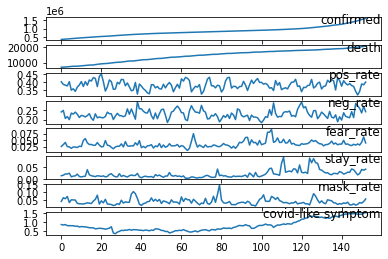

In [24]:
# load dataset confirmed and death is different dataset! but same procedure, the only thing has to change is the amount of feautres

dataset = read_csv('predconfirmed_cumu_CA_08_12_FT.csv', header=0, index_col=0)#here!!
values = dataset.values
# specify columns to plot
#groups = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]#full feature #here!
#groups = [0, 1, 2]#only F
#groups = [0, 1, 2, 3]#only G
#groups = [0, 1, 2, 3, 4, 5, 6]#only T

#groups = [0, 1, 2, 3, 4]# FG
groups = [0, 1, 2, 3, 4, 5, 6, 7]# FT
#groups = [0, 1, 2, 3, 4, 5, 6, 7, 8]#only GT

i = 1
# plot each column
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

In [14]:
# prepare data for lstm

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [25]:
# load dataset
dataset = read_csv('predconfirmed_cumu_CA_08_12_FT.csv', header=0, index_col=0)#here!!
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
#values[:,4] = encoder.fit_transform(values[:,4])#here!? only when this column is strings!!!
# ensure all data is float
values = values.astype('float32')
# normalize features
#scaled = values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag hours
n_back = 3
#n_features = 10# full feature #here!

#n_features = 3# only F
#n_features = 4# only G
#n_features = 7# only T

#n_features = 5# FG
n_features = 8# FT
#n_features = 9# GT
# frame as supervised learning
reframed = series_to_supervised(scaled, n_back, 1)
print(reframed.head())

   var1(t-3)  var2(t-3)  var3(t-3)  var4(t-3)  var5(t-3)  var6(t-3)  \
3   0.000000   0.000000   0.628276   0.510779   0.191298   0.120142   
4   0.008757   0.001885   0.503464   0.584952   0.276941   0.140955   
5   0.015485   0.011093   0.464485   0.205609   0.383452   0.202004   
6   0.023360   0.019648   0.430719   0.291436   0.182141   0.201157   
7   0.030393   0.028420   0.631350   0.147535   0.171413   0.239169   

   var7(t-3)  var8(t-3)  var1(t-2)  var2(t-2)  ...  var7(t-1)  var8(t-1)  \
3   0.216575   0.436630   0.008757   0.001885  ...   0.345504   0.435442   
4   0.392854   0.417234   0.015485   0.011093  ...   0.454671   0.384809   
5   0.345504   0.435442   0.023360   0.019648  ...   0.165164   0.382301   
6   0.454671   0.384809   0.030393   0.028420  ...   0.294002   0.380499   
7   0.165164   0.382301   0.037132   0.035888  ...   0.287612   0.381825   

    var1(t)   var2(t)   var3(t)   var4(t)   var5(t)   var6(t)   var7(t)  \
3  0.023360  0.019648  0.430719  0.291436

In [26]:
# split into train and test sets
values = reframed.values
n_train_days = 120#here!!
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
n_obs = n_back * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]#predict confirmed, which is in the first column
test_X, test_y = test[:, :n_obs], test[:, -n_features]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(120, 1, 24) (120,) (30, 1, 24) (30,)


In [27]:
print(train_X.shape, len(train_X), train_y.shape)

(120, 1, 24) 120 (120,)


In [28]:
from keras import backend as K
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

Epoch 1/200
2/2 - 0s - loss: 0.3116 - val_loss: 0.6463
Epoch 2/200
2/2 - 0s - loss: 0.2712 - val_loss: 0.5832
Epoch 3/200
2/2 - 0s - loss: 0.2324 - val_loss: 0.5207
Epoch 4/200
2/2 - 0s - loss: 0.1958 - val_loss: 0.4591
Epoch 5/200
2/2 - 0s - loss: 0.1627 - val_loss: 0.3993
Epoch 6/200
2/2 - 0s - loss: 0.1351 - val_loss: 0.3428
Epoch 7/200
2/2 - 0s - loss: 0.1151 - val_loss: 0.2914
Epoch 8/200
2/2 - 0s - loss: 0.1027 - val_loss: 0.2468
Epoch 9/200
2/2 - 0s - loss: 0.0973 - val_loss: 0.2106
Epoch 10/200
2/2 - 0s - loss: 0.1008 - val_loss: 0.1859
Epoch 11/200
2/2 - 0s - loss: 0.1105 - val_loss: 0.1741
Epoch 12/200
2/2 - 0s - loss: 0.1152 - val_loss: 0.1729
Epoch 13/200
2/2 - 0s - loss: 0.1123 - val_loss: 0.1798
Epoch 14/200
2/2 - 0s - loss: 0.1046 - val_loss: 0.1929
Epoch 15/200
2/2 - 0s - loss: 0.0975 - val_loss: 0.2083
Epoch 16/200
2/2 - 0s - loss: 0.0939 - val_loss: 0.2211
Epoch 17/200
2/2 - 0s - loss: 0.0917 - val_loss: 0.2287
Epoch 18/200
2/2 - 0s - loss: 0.0899 - val_loss: 0.2310
E

Epoch 147/200
2/2 - 0s - loss: 0.0066 - val_loss: 0.1357
Epoch 148/200
2/2 - 0s - loss: 0.0067 - val_loss: 0.1324
Epoch 149/200
2/2 - 0s - loss: 0.0073 - val_loss: 0.1332
Epoch 150/200
2/2 - 0s - loss: 0.0066 - val_loss: 0.1336
Epoch 151/200
2/2 - 0s - loss: 0.0068 - val_loss: 0.1329
Epoch 152/200
2/2 - 0s - loss: 0.0063 - val_loss: 0.1329
Epoch 153/200
2/2 - 0s - loss: 0.0065 - val_loss: 0.1334
Epoch 154/200
2/2 - 0s - loss: 0.0063 - val_loss: 0.1317
Epoch 155/200
2/2 - 0s - loss: 0.0067 - val_loss: 0.1325
Epoch 156/200
2/2 - 0s - loss: 0.0063 - val_loss: 0.1318
Epoch 157/200
2/2 - 0s - loss: 0.0066 - val_loss: 0.1316
Epoch 158/200
2/2 - 0s - loss: 0.0061 - val_loss: 0.1315
Epoch 159/200
2/2 - 0s - loss: 0.0063 - val_loss: 0.1316
Epoch 160/200
2/2 - 0s - loss: 0.0060 - val_loss: 0.1304
Epoch 161/200
2/2 - 0s - loss: 0.0063 - val_loss: 0.1309
Epoch 162/200
2/2 - 0s - loss: 0.0060 - val_loss: 0.1299
Epoch 163/200
2/2 - 0s - loss: 0.0063 - val_loss: 0.1299
Epoch 164/200
2/2 - 0s - loss: 

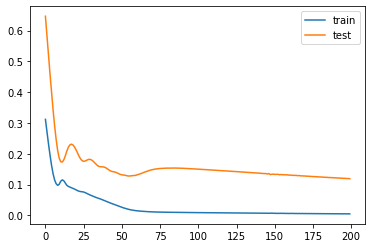

In [29]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss=root_mean_squared_error, optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=200, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [30]:
# make a prediction
yhat = model.predict(test_X)
test_X_re = test_X.reshape((test_X.shape[0], n_obs))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X_re[:, -n_features+1:]), axis=1)#-6 for 7 features -1 object
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]#it is our prediction
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X_re[:, -n_features+1:]), axis=1)#-6 for 7 features -1 object
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
import numpy as np
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
#inv_y_norm = np.linalg.norm(inv_y, ord=None, axis=None, keepdims=False)
print('Test RMSE: %.3f' % rmse)
print('Test normalized RMSE: %.3f' % (rmse/np.mean(inv_y)))

Test RMSE: 150593.312
Test normalized RMSE: 0.120


In [31]:
rmse5 = sqrt(mean_squared_error(inv_y[:5], inv_yhat[:5]))
inv_y_norm5 = np.linalg.norm(inv_y[:5], ord=None, axis=None, keepdims=False)
print('Test RMSE5: %.3f' % rmse5)
print('Test normalized RMSE5: %.3f' % (rmse5/np.mean(inv_y)))

Test RMSE5: 22404.384
Test normalized RMSE5: 0.018


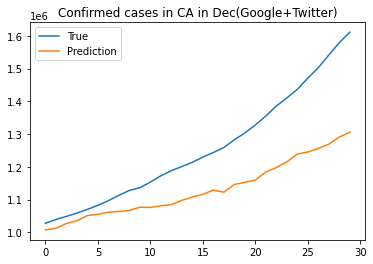

In [32]:
pyplot.plot(inv_y, label="True")
pyplot.plot(inv_yhat, label="Prediction")
pyplot.legend(loc="upper left")
pyplot.title('Confirmed cases in CA in Dec(Google+Twitter)')#here!!!
#pyplot.title('Confirmed cases in CA in Dec(G+F)')
#pyplot.title('Confirmed cases in CA in Dec(T)')
# Facebook
# Twitter
# Google
pyplot.show()

In [66]:
def data_gen():
    while True:
        x = np.random.rand(5, 10, 3)  # batch x time x features
        yield x, x[:, :, 0] * x[:, :, 1] < 0.25

In [67]:
def var_importance(model):
    g = data_gen()
    x = np.concatenate([next(g)[0] for _ in range(50)]) # Get a sample of data
    orig_out = model.predict(x)
    for i in range(7):  # iterate over the three features
        new_x = x.copy()
        perturbation = np.random.normal(0.0, 0.2, size=new_x.shape[:2])
        new_x[:, :, i] = new_x[:, :, i] + perturbation
        perturbed_out = model.predict(new_x)
        effect = ((orig_out - perturbed_out) ** 2).mean() ** 0.5
        print(f'Variable {i+1}, perturbation effect: {effect:.4f}')

In [68]:
orig_out = yhat
for i in range(n_features):  # iterate over the three features
    new_x = test_X.copy()
    #perturbation = np.random.normal(0.0, 0.2, size=new_x.shape[:2])
    #new_x[:, :, i] = new_x[:, :, i] + perturbation
    perturbation = 1.2
    new_x[:, :, i] = new_x[:, :, i] * perturbation
    perturbed_out = model.predict(new_x)
    effect = ((orig_out - perturbed_out) ** 2).mean() ** 0.5
    print(f'Variable {i+1}, perturbation effect: {effect:.4f}')

Variable 1, perturbation effect: 0.0140
Variable 2, perturbation effect: 0.0185
Variable 3, perturbation effect: 0.0014
Variable 4, perturbation effect: 0.0019
Variable 5, perturbation effect: 0.0005
Variable 6, perturbation effect: 0.0009
Variable 7, perturbation effect: 0.0002
Variable 8, perturbation effect: 0.0014
